## Importing Dependencies
Starting with importing all the necessary dependencies.

In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re
import warnings
warnings.filterwarnings('ignore')

print("Tensorflow Version",tf.__version__)


Tensorflow Version 2.15.0


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\KUSHAL
[nltk_data]     SINGH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Dataset Preprocessing
In this notebook, I am using the Sentiment140 dataset from Kaggle. It contains labelled data of 1.6 million tweets.
here is the link to dataset: [Kaggle](https://www.kaggle.com/datasets/kazanova/sentiment140)

In [4]:
dataset_cols = ["target", "ids", "date", "flag", "user", "text"]
dataset_encoding = "ISO-8859-1"
# df = pd.read_csv('/kaggle/input/dataset/training.1600000.processed.noemoticon.csv', encoding=dataset_encoding, names=dataset_cols)
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding=dataset_encoding, names=dataset_cols)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


We only need to extract the sentiments from the tweets text irrespective of the username, time, and id, so we can drop them;

In [5]:
df = df.drop(['ids', 'date', 'flag', 'user'], axis=1)

In the target column, '0' denotes 'Negative' and '4' denotes 'Positive'

In [6]:
label_sentiment = {0: 'Negative', 4:'Positive'}
def label_decoder(label):
    return label_sentiment[label]
df.target = df.target.apply(lambda x: label_decoder(x))
df.head()

,target,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


In [7]:
df['target'].value_counts()

Negative    800000
Positive    800000
Name: target, dtype: int64

<Axes: xlabel='target', ylabel='count'>

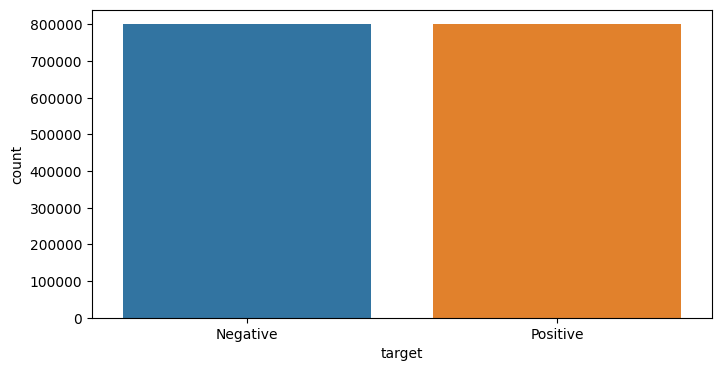

In [8]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='target')

In [9]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,target,text
735098,Negative,ACCIDENTLY got juice in my kitty's eye. oops.
919692,Positive,"Last night, bad guys tried to enter in my gard..."
804236,Positive,@RobPattinson_ follow me ?
976636,Positive,"The fans on, my feetsies are inside the covers..."
600149,Negative,attending my last day of high school. i love...
281967,Negative,[dso] why are you crashing?
352716,Negative,Having a flat tire in your girlfriends car on ...
703447,Negative,"@Lilimich I know Can't buy stuff,can't enter ..."
1364550,Positive,Almost Off Work... Yeeeeeeesssssss
1109510,Positive,i might get a drum set! woooo


## Text Preprocessing

I can see that there are some irrelevant stuff in the texts such as usernames, uppercases, etc. They should be removed.

Tweet texts often consists of other user mentions, hyperlink texts, emoticons and punctuations. In order to use them for learning using a Language Model, we cannot permit those texts for training a model. So we have to clean the text data using various preprocessing and cleansing methods. Let's continue

In [10]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

Stemming and Removing hyperlinks and mentions

In [11]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))

Now, our texts are all clean and tidy. So let's see some word cloud visualisations of negative texts and positive texts.

In [12]:
# pip install wordcloud

#### Positive words

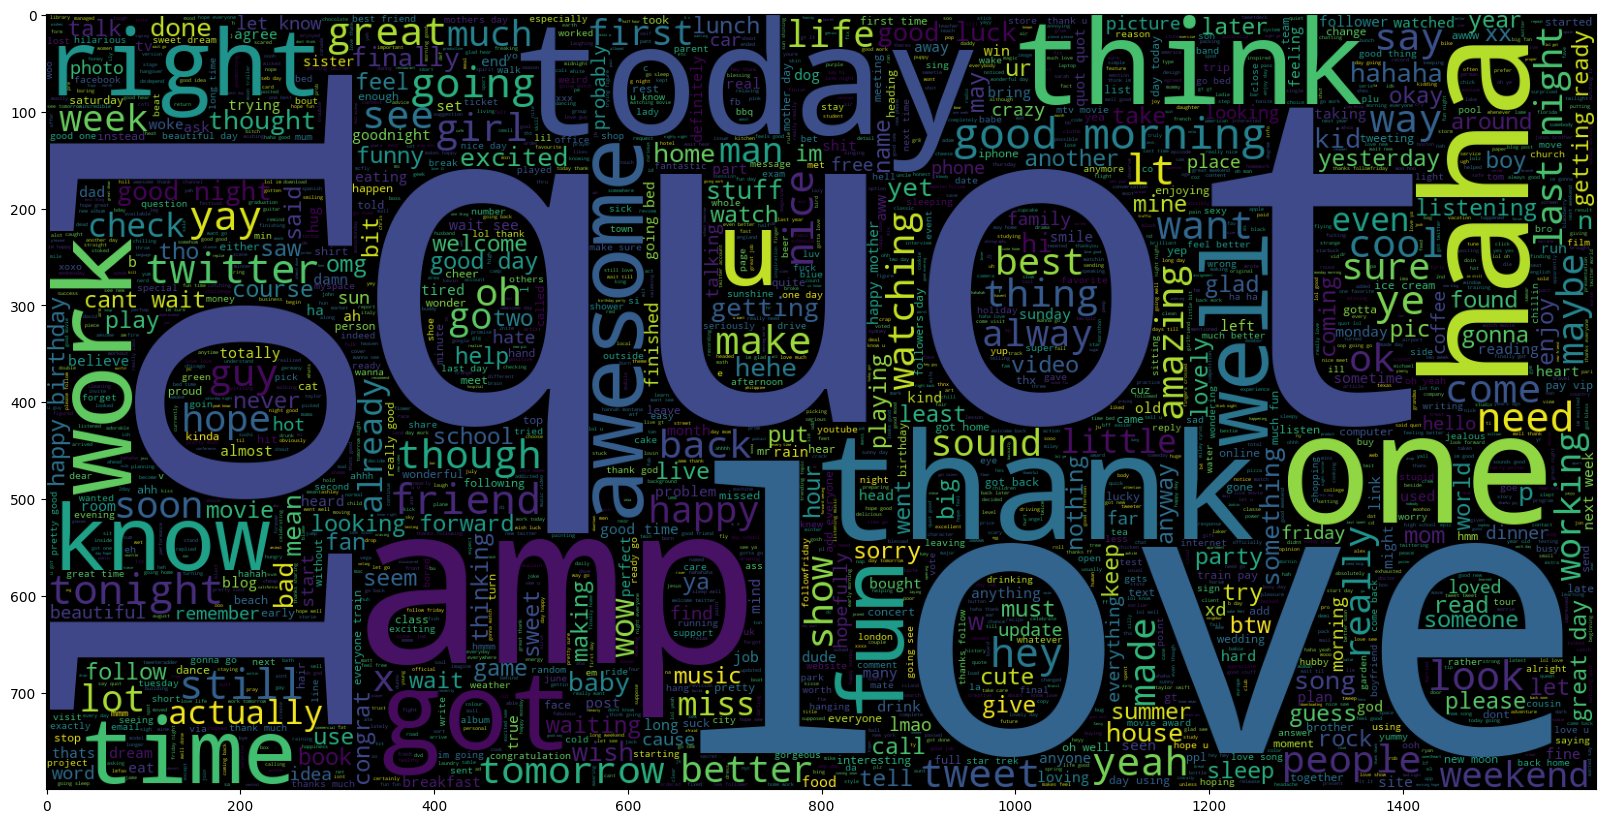

In [13]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.target == 'Positive'].text))
plt.imshow(wc)

#### Negative words

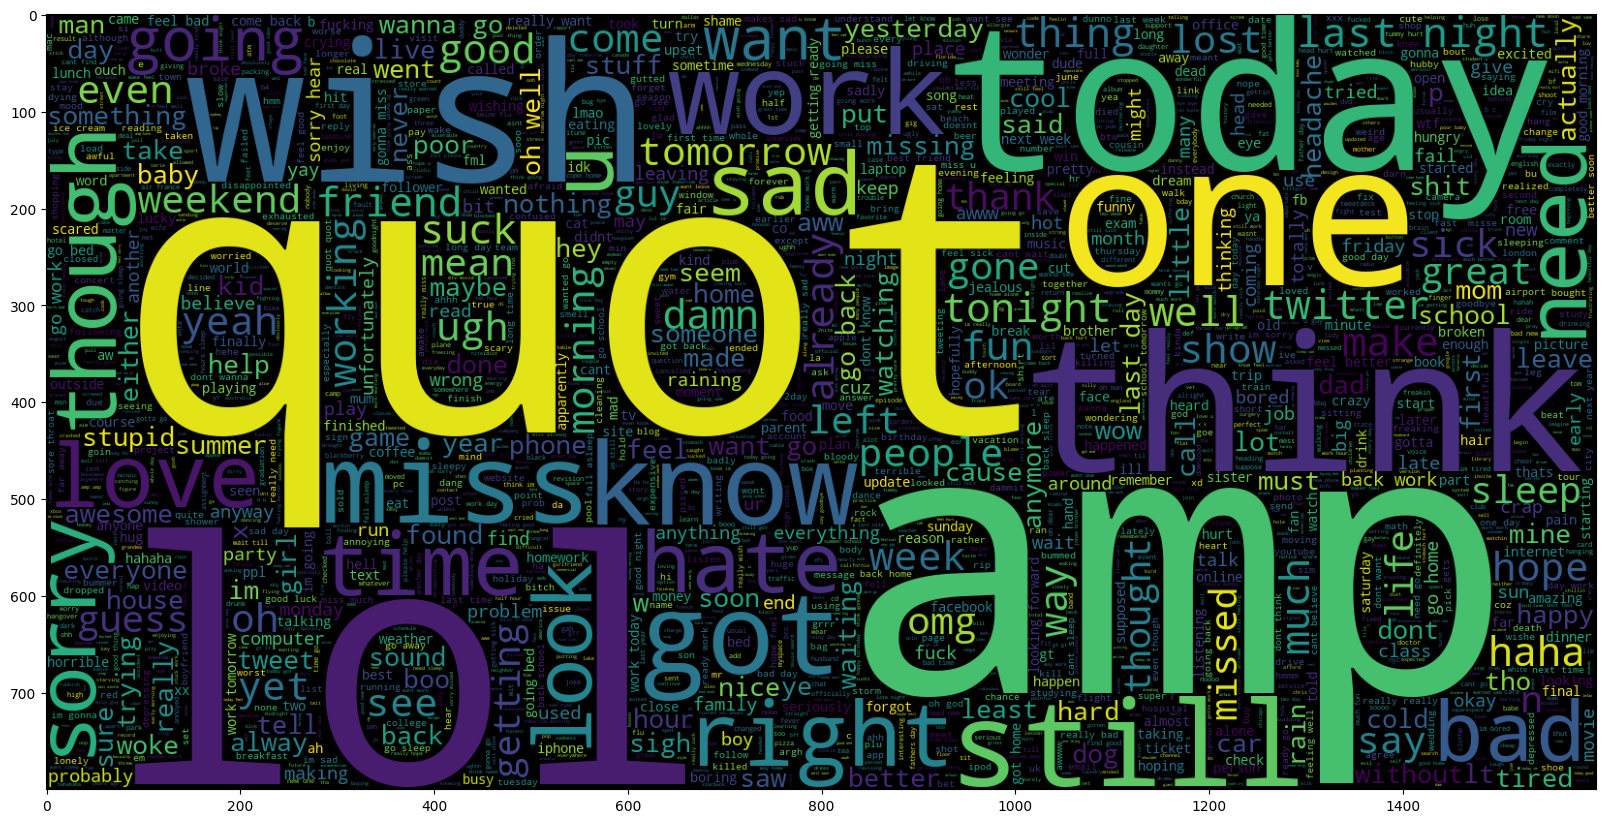

In [14]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.target == 'Negative'].text))
plt.imshow(wc)

## Train and Test Split

In [15]:
train_size = 0.8
max_nb_words = 100000
max_seq_length = 30

In [16]:
train_data, test_data = train_test_split(df, test_size=1-train_size,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [17]:
train_data.head()

,target,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...


## Tokenization

Cutting a character sequence into pieces

In [18]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size: ", vocab_size)

Vocabulary Size:  290575


In [19]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = max_seq_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = max_seq_length)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


## Label Encoding

we are essentially building a model to predict the class (negative or postive), i.e. Binary Classification, so let's encode out training labels to encodings.

In [20]:
labels = train_data.target.unique().tolist()

In [21]:
encoder = LabelEncoder()
encoder.fit(train_data.target.to_list())

y_train = encoder.transform(train_data.target.to_list())
y_test = encoder.transform(test_data.target.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


## Word Embedding

In Language Model, words are represented in a way to intend more meaning and for learning the patterns and contextual meaning behind it.

Word Embedding is one of the popular representation of document vocabulary.It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Basically, it's a feature vector representation of words which are used for other natural language processing applications.

In this notebook, I am using GloVe Embedding from Stanford AI available at [link](https://nlp.stanford.edu/projects/glove/)

In [22]:
print(os.listdir())

['.ipynb_checkpoints', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt', 'glove.6B.50d.txt', 'glove.6B.zip', 'training.1600000.processed.noemoticon.csv', 'twitter-sentiment-analysis.ipynb']


In [23]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# unzip glove.6B.zip

In [24]:
# GLOVE_EMB = '/kaggle/working/glove.6B.300d.txt'
# GLOVE_EMB = '../input/gloves/glove.6B.300d.txt'
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [25]:
embeddings_index = {}

f = open(GLOVE_EMB, encoding='utf8')
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [26]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [27]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=max_seq_length,
                                          trainable=False)

## Model Training (using LSTMs)

As observed in the word clouds, some words are predominantly featured in both Positive and Negative tweets. This could be a problem if we are using a Machine Learning model like Naive Bayes, SVD, etc.. That's why I am using Sequence Models.

For our model, we use:
1. **Embedding Layer -** Generates Embedding Vector for each input sequence 

2. **Conv1D Layer -** Used to Convolve data into smaller feature vectors

3. **LSTM -** Long Short Term Memory, a variant of RNN is used to learn the context of words which are further along the text to carry the meaning

4. **Dense -** Used for Output Layer to give output

In [28]:
model = keras.Sequential([
    layers.Input(shape=(max_seq_length,), dtype='int32'),
    layers.Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_seq_length, trainable=False),
    layers.SpatialDropout1D(0.2),
    layers.Conv1D(64, 5, activation='relu'),
    layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

## Optimization Algorithms and Callbacks
Here I am using the Adam Optmization algorithm for gradient descent.

Callbacks are functions which are called at the end of an epoch and are generally used for early pruning of the training in case the model's accuracy doesn't increase by atleast some predefined threshold for certain number of epochs.

I am using two callbacks in the model:
1. **LRScheduler** - It changes the Learning Rate at specfic epoch to achieve more improved result. In this notebook, the learning rate exponentionally decreases after remaining same for first 10 Epoch.
2. **ModelCheckPoint** - It saves best model while training based on some metrics. Here, it saves the model with minimum Validity Loss.

In [29]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr=0.01, monitor='val_loss', verbose=1)

In [30]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on CPU...


In [31]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10


1250/1250 [==============================] - 528s 418ms/step - loss: 0.5187 - accuracy: 0.7396 - val_loss: 0.4860 - val_accuracy: 0.7617 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 503s 402ms/step - loss: 0.4874 - accuracy: 0.7626 - val_loss: 0.4734 - val_accuracy: 0.7710 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 520s 416ms/step - loss: 0.4765 - accuracy: 0.7696 - val_loss: 0.4654 - val_accuracy: 0.7757 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 472s 377ms/step - loss: 0.4702 - accuracy: 0.7737 - val_loss: 0.4636 - val_accuracy: 0.7776 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 480s 384ms/step - loss: 0.4660 - accuracy: 0.7759 - val_loss: 0.4617 - val_accuracy: 0.7797 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 457s 366ms/step - loss: 0.4623 - accuracy: 0.7786 - val_loss: 0.4584 - val_accuracy: 0.7811 - lr: 0.0010
Epoch 7/10
1250/1250 [==========

## Model Evaluation
Now that we've trained our model, we can evaluate its performance.
Lets have a look at its learning and accuracy curve on each epoch.

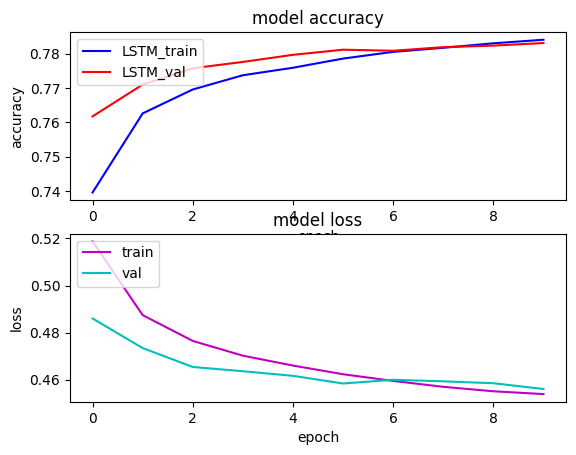

In [32]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

Our model will predict a score between 0 and 1. We can obtain our classification by setting a suitable threshold. Here, we can set all values greater than 0.5 to be classified as Positive Sentiment, Negative otherwise.

In [33]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 31s 960ms/step


### Confusion Matrix Plot

In [34]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

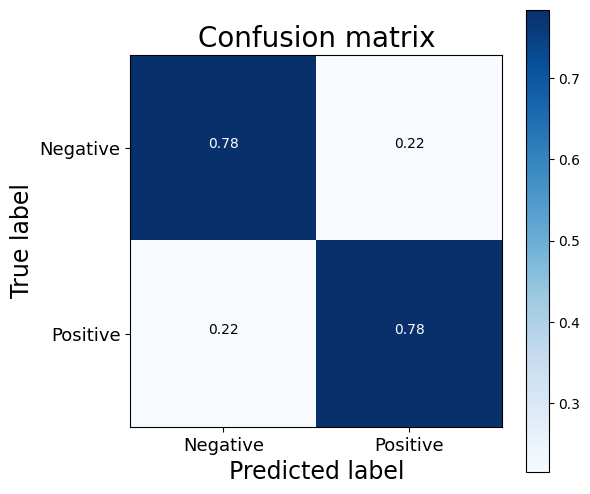

In [36]:
cnf_matrix = confusion_matrix(test_data.target.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.target.unique(), title="Confusion matrix")
plt.show()

## Classification Scores

In [38]:
print(classification_report(list(test_data.target), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.78      0.78      0.78    160542
    Positive       0.78      0.78      0.78    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000

